Bitcoin price prediction

import important libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import plotly.express as px


from itertools import cycle
from tensorflow import keras
from keras.utils import normalize,to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM,Activation, Dropout, Dense,Bidirectional, Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report


load dataset

In [4]:
dataset=pd.read_csv('/content/BTC-USD.csv')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       367 non-null    object 
 1   Open       367 non-null    float64
 2   High       367 non-null    float64
 3   Low        367 non-null    float64
 4   Close      367 non-null    float64
 5   Adj Close  367 non-null    float64
 6   Volume     367 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 20.2+ KB


In [6]:
dataset.shape


(367, 7)

In [7]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359,27192.693359,14413231792
1,2023-05-16,27171.513672,27299.304688,26878.947266,27036.650391,27036.650391,12732238816
2,2023-05-17,27035.470703,27465.927734,26600.144531,27398.802734,27398.802734,15140006925
3,2023-05-18,27401.650391,27466.527344,26415.101563,26832.208984,26832.208984,15222938600
4,2023-05-19,26826.753906,27128.619141,26700.210938,26890.128906,26890.128906,11258983301


In [8]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,367.000000,367.000000,367.000000,367.000000,367.000000,3.670000e+02
mean,40766.791133,41550.568562,40017.537876,40871.348018,40871.348018,2.220767e+10
std,14783.770252,15240.056658,14241.015215,14821.148114,14821.148114,1.410956e+10
min,25121.673828,25735.308594,24797.167969,25124.675781,25124.675781,5.331173e+09
25%,27866.559570,28222.993164,27325.174804,27940.843750,27940.843750,1.271787e+10
50%,36585.765625,37407.093750,35813.812500,36596.683594,36596.683594,1.829616e+10
75%,49837.402344,50928.162110,48851.664062,50345.085938,50345.085938,2.671690e+10
max,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,1.028029e+11


check null values

In [9]:
print('Null:',dataset.isnull().values.sum())


Null: 0


check starting and ending date

In [10]:
sd=dataset.iloc[0][0]
ed=dataset.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2023-05-15
Ending Date 2024-05-15


overall analysis

In [11]:
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m-%d')

y_overall = dataset.loc[(dataset['Date'] >= '2023-05-15')
                     & (dataset['Date'] <= '2024-05-15')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359
1,2023-05-16,27171.513672,27299.304688,26878.947266,27036.650391
2,2023-05-17,27035.470703,27465.927734,26600.144531,27398.802734
3,2023-05-18,27401.650391,27466.527344,26415.101563,26832.208984
4,2023-05-19,26826.753906,27128.619141,26700.210938,26890.128906
...,...,...,...,...,...
362,2024-05-11,60793.355469,61451.152344,60492.625000,60793.710938
363,2024-05-12,60793.503906,61818.156250,60632.601563,61448.394531
364,2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219
365,2024-05-14,62900.773438,63092.125000,61123.765625,61552.789063


order data by months

In [12]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,42910.015373,42919.612399
February,49231.727101,49875.174300
March,67372.752394,67702.439264
April,66239.900912,65882.380599
May,43317.445068,43471.251953
June,27651.926758,27763.198438
July,30098.767578,30057.469947
August,27959.756615,27852.792843
September,26271.268229,26306.136393


plot stock analysis

In [13]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'],
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

Build model

dataframe for date and close

In [14]:

closedf = dataset[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (367, 2)


plot all period of timeframe

In [15]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2023-2024', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

preprocessing

In [16]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(367, 1)


In [17]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (220, 1)
test_data:  (147, 1)


In [18]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(204, 15)
(131, 15)
(204,)
(131,)


In [20]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print( X_train.shape)
print( X_test.shape)

(204, 15, 1)
(131, 15, 1)


build LSTM model

In [21]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))



print  model summary

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


compile the model

In [23]:
model.compile(loss="mean_squared_error",optimizer="adam")

fit the model

In [24]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=250, batch_size=128)

Epoch 1/250
2/2 [==============================] - 2s 335ms/step - loss: 0.0168 - val_loss: 0.3315
Epoch 2/250
2/2 [==============================] - 0s 56ms/step - loss: 0.0153 - val_loss: 0.3155
Epoch 3/250
2/2 [==============================] - 0s 45ms/step - loss: 0.0139 - val_loss: 0.2999
Epoch 4/250
2/2 [==============================] - 0s 57ms/step - loss: 0.0126 - val_loss: 0.2846
Epoch 5/250
2/2 [==============================] - 0s 58ms/step - loss: 0.0114 - val_loss: 0.2696
Epoch 6/250
2/2 [==============================] - 0s 55ms/step - loss: 0.0103 - val_loss: 0.2550
Epoch 7/250
2/2 [==============================] - 0s 60ms/step - loss: 0.0094 - val_loss: 0.2408
Epoch 8/250
2/2 [==============================] - 0s 56ms/step - loss: 0.0084 - val_loss: 0.2271
Epoch 9/250
2/2 [==============================] - 0s 62ms/step - loss: 0.0077 - val_loss: 0.2139
Epoch 10/250
2/2 [==============================] - 0s 56ms/step - loss: 0.0070 - val_loss: 0.2013
Epoch 11/250
2/2 [

plot loss of training and validation

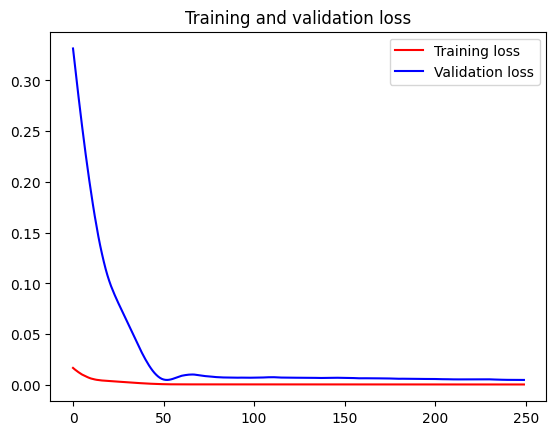

<Figure size 640x480 with 0 Axes>

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

prediction

In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

5/5 [==============================] - 0s 4ms/step
(204, 1)
(131, 1)


prediction for next 60 days

In [27]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 60
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])

        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]


        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  60


plot predictio of 60 days

In [28]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()